# Handling duplicated proxies in a `ProxyDatabase`

Sometimes we may have duplicated proxies in a `ProxyDatabase` whose time series values are highly correlated to each other, which can cause problem for climate field reconstruction algorithms like GraphEM.
Therefore, we need to find and remove the duplicates ahead.
This notebook shows how to achive that goal with the `cfr` utilities.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt

## Load a database with duplicated proxies

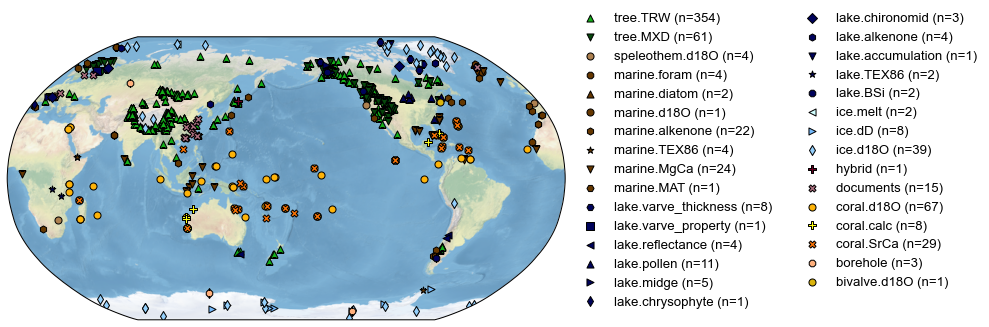

In [2]:
# load a proxy database
job = cfr.ReconJob()
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10_bug.pkl')
fig, ax = job.proxydb.plot()

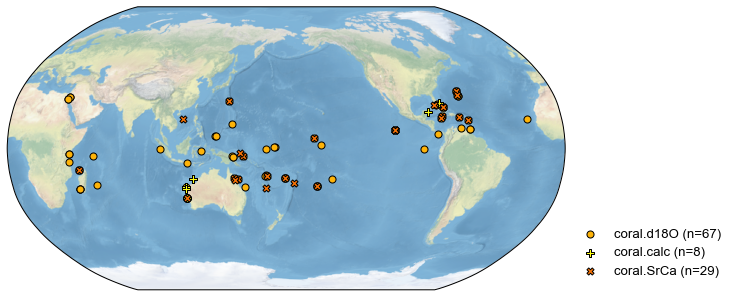

In [3]:
# filter the database
job.proxydb = job.proxydb.filter(by='ptype', keys='coral')
fig, ax = job.proxydb.plot()

In [4]:
job.proxydb = job.proxydb.center([1951, 1980])

Centering each of the ProxyRecord: 100%|██████████| 104/104 [00:00<00:00, 7835.31it/s]


## Find the duplicates

>>> Groups of duplicates:
0 {'Ocn_141', 'Ocn_065', 'Ocn_140', 'Ocn_142', 'Ocn_143', 'Ocn_060', 'Ocn_070', 'Ocn_110'}
1 {'Ocn_156', 'Ocn_075', 'Ocn_157'}
2 {'Ocn_076', 'Ocn_078'}
3 {'Ocn_093', 'Ocn_106', 'Ocn_095', 'Ocn_091'}
4 {'Ocn_125', 'Ocn_096', 'Ocn_178', 'Ocn_127'}
5 {'Ocn_138', 'Ocn_144', 'Ocn_145', 'Ocn_069', 'Ocn_066', 'Ocn_067', 'Ocn_068'}
6 {'Ocn_114', 'Ocn_153', 'Ocn_158'}
7 {'Ocn_071', 'Ocn_150', 'Ocn_111', 'Ocn_168', 'Ocn_147', 'Ocn_072', 'Ocn_151', 'Ocn_169', 'Ocn_112', 'Ocn_152', 'Ocn_149'}
8 {'Ocn_177', 'Ocn_103', 'Ocn_128', 'Ocn_098', 'Ocn_129', 'Ocn_107'}
9 {'Ocn_080', 'Ocn_082'}
10 {'Ocn_173', 'Ocn_171'}
11 {'Ocn_181', 'Ocn_123', 'Ocn_108', 'Ocn_182'}
12 {'Ocn_115', 'Ocn_116'}
13 {'Ocn_172', 'Ocn_118', 'Ocn_174', 'Ocn_170'}
14 {'Ocn_180', 'Ocn_166', 'Ocn_179', 'Ocn_090', 'Ocn_097'}
15 {'Ocn_154', 'Ocn_155'}
16 {'Ocn_130', 'Ocn_131'}
17 {'Ocn_061', 'Ocn_062', 'Ocn_139', 'Ocn_077', 'Ocn_083'}
18 {'Ocn_119', 'Ocn_104', 'Ocn_160', 'Ocn_161', 'Ocn_163', 'Ocn_159', 'Ocn_1

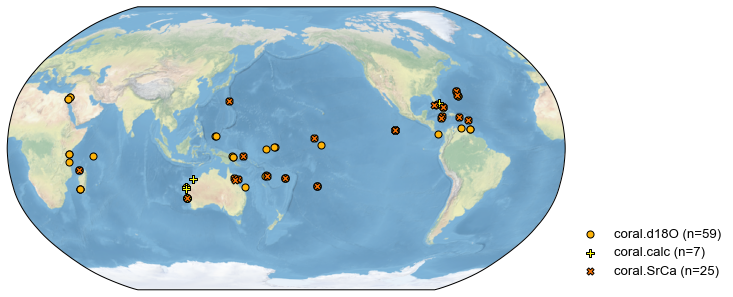

In [9]:
# r_thresh = 0.9 by default, R >= r_thresh will be regarded as dupilicates
pdb_dups = job.proxydb.find_duplicates(r_thresh=0.9, time_period=[1001, 2000])
fig, ax = pdb_dups.plot()

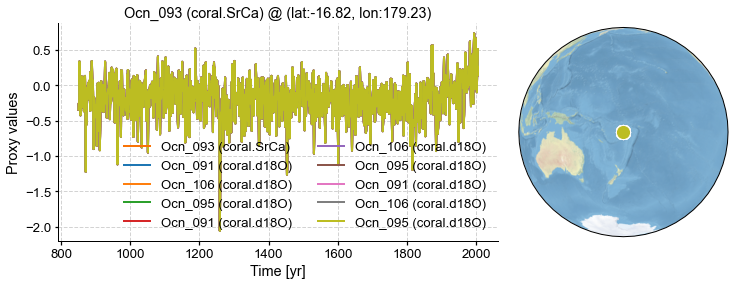

In [12]:
fig, ax = pdb_dups.records['Ocn_093'].plot_dups(lgd_kws={'ncol': 2})

In [13]:
# squeeze the dupilicates manually
# pids_to_keep = ['Ocn_178', 'Ocn_106', 'Ocn_179', 'Ocn_160', 'Ocn_170', 'Ocn_076', 'Ocn_082', 'Ocn_181', 'Ocn_164', 'Ocn_121', 'Ocn_130', 'Ocn_083', 'Ocn_143', 'Ocn_116', 'Ocn_158', 'Ocn_066', 'Ocn_150', 'Ocn_103', 'Ocn_154', 'Ocn_075', 'Ocn_171']
# pdb_to_keep = pdb_dups.squeeze_dups(pids_to_keep=pids_to_keep)

In [14]:
# squeeze the dupilicates automatically
pdb_to_keep = pdb_dups.squeeze_dups()

>>> Note: since `pids_to_keep` is not specified, the first of each group of the duplicates is picked.
>>> pids to keep (n=21):
{'Ocn_093', 'Ocn_138', 'Ocn_119', 'Ocn_071', 'Ocn_176', 'Ocn_141', 'Ocn_125', 'Ocn_114', 'Ocn_120', 'Ocn_156', 'Ocn_177', 'Ocn_181', 'Ocn_076', 'Ocn_061', 'Ocn_180', 'Ocn_154', 'Ocn_080', 'Ocn_115', 'Ocn_172', 'Ocn_173', 'Ocn_130'}


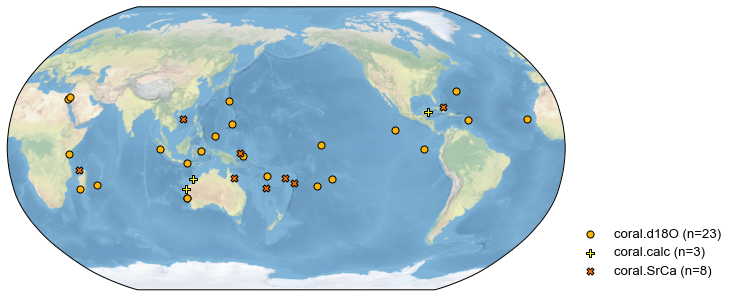

In [15]:
# update the proxy database, excluding duplicates
job.proxydb = job.proxydb - pdb_dups + pdb_to_keep
fig, ax = job.proxydb.plot()

## Test GraphEM

In [16]:
# load observations
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


In [17]:
# regrid and crop obs to make the problem size smaller
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
#job.regrid_clim(tag='obs', nlat=32, nlon=50, verbose=True)
job.crop_clim(tag='obs', lat_min=-25, lat_max=25, lon_min=120, lon_max=280, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -25
>>> job.configs["prior_lat_max"] = 25
>>> job.configs["prior_lon_min"] = 120
>>> job.configs["prior_lon_max"] = 280
>>> Processing tas ...


>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.obs updated


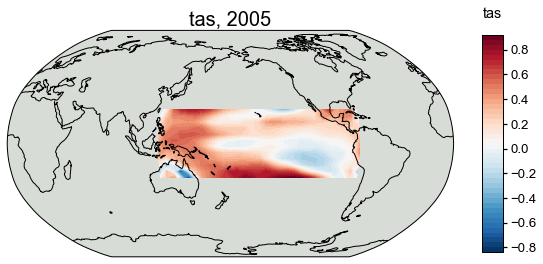

In [18]:
job.annualize_clim(tag='obs', verbose=True, months=list(range(1, 13)))
fig, ax = job.obs['tas'].plot(it=-1)

In [19]:
job.prep_graphem(
    recon_period=(1001, 2000),
    calib_period=(1850, 2000),
    verbose=True)

>>> job.recon_time created
>>> job.calib_time created
>>> job.calib_idx created
>>> job.temp created
>>> job.df_proxy created
>>> job.proxy created
>>> job.lonlat created


In [20]:
job.df_proxy

,Ocn_167,Ocn_086,Ocn_101,Ocn_099,Ocn_088,Ocn_084,Ocn_073,Ocn_081,Ocn_074,Ocn_079,...,Ocn_114,Ocn_176,Ocn_120,Ocn_173,Ocn_061,Ocn_156,Ocn_181,Ocn_125,Ocn_119,Ocn_071
1001.0,0.898822,0.029546,-0.185165,0.235898,-0.366383,-0.826732,-0.571113,-0.543309,-0.095079,0.098754,...,-0.348730,-0.066268,1.130590,-0.037313,-0.663207,-0.205720,-0.255808,0.425059,-0.756506,-0.395720
1002.0,-0.215733,-0.366285,-0.751944,-0.589594,-0.709740,-0.668547,-0.485664,-0.540698,-0.451790,-0.538710,...,-0.293169,-0.833021,0.293682,-0.840724,-0.790299,-0.380234,-0.922958,-0.455390,-0.212252,-0.374382
1003.0,0.439043,-0.243331,-0.202119,-0.514341,-0.279519,-0.006054,-0.114589,-0.200504,-0.160557,-0.195342,...,0.440870,-0.462956,0.657985,0.200977,0.061147,0.186897,0.117084,-0.364133,-0.067308,0.223871
1004.0,0.381423,0.171702,0.404180,0.157582,-0.006598,-0.132344,-0.316654,-0.406022,0.001588,0.055546,...,-0.066871,0.377637,0.609900,-0.188294,-0.318401,-0.023028,0.407428,0.255347,-0.416455,-0.159114
1005.0,0.186128,-0.152617,-0.247644,0.170491,-0.276179,0.046075,-0.216756,-0.488320,-0.420469,0.045561,...,-0.108365,-0.445715,0.267414,-0.544992,-0.685244,-0.203502,-0.050030,-0.190592,-0.461959,-0.441364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996.0,0.143895,-0.030944,0.308333,-0.109840,0.076432,0.443499,0.558331,0.614777,0.096091,0.041014,...,0.888607,0.310897,0.022645,0.487655,0.615085,0.291426,0.341098,-0.664192,0.497055,0.342945
1997.0,-0.058669,0.313273,0.388179,0.635640,0.525582,0.533289,0.101198,-0.003772,0.318022,0.687141,...,0.074774,0.565047,-0.608476,0.016154,0.289483,0.197638,0.309060,0.580503,0.012817,-0.219055
1998.0,-0.710221,0.194011,0.340377,0.177812,0.236113,0.547631,0.441170,0.307208,0.275842,0.258968,...,0.525448,0.133211,-0.417760,0.337575,0.406999,0.620285,0.543253,0.355502,0.680764,0.015942
1999.0,0.114631,0.322021,0.886320,0.398480,0.265992,0.703740,0.573262,0.770644,0.169370,0.102518,...,0.587975,0.234067,-0.128660,0.131140,0.645682,0.049518,0.655754,-0.012054,0.386616,0.454576


In [21]:
%%time
# need to remove G.pkl if the previous run is problematic
save_path = './results/graphem-ppe-pages2k-dups/G.pkl'
job.run_graphem(
    save_path=save_path,
    load_precalculated=False,
    verbose=True,
)

Computing a neighborhood graph with R = 1000.0 km
Estimating graph using neighborhood method
Running GraphEM:

Iter     dXmis     rdXmis

001     0.0551     0.7999
002     0.0687     0.7718
003     0.0799     0.6769
004     0.0621     0.3326
005     0.0447     0.1839
006     0.0366     0.1300
007     0.0341     0.1098
008     0.0340     0.1012
009     0.0339     0.0938
010     0.0334     0.0864
011     0.0326     0.0792
012     0.0312     0.0714
013     0.0282     0.0615
014     0.0251     0.0524
015     0.0211     0.0425
016     0.0188     0.0369
017     0.0165     0.0316
018     0.0151     0.0284
019     0.0143     0.0266
020     0.0127     0.0233
021     0.0130     0.0237
022     0.0118     0.0214
023     0.0126     0.0227
024     0.0114     0.0205
025     0.0107     0.0192
026     0.0120     0.0215
027     0.0096     0.0172
028     0.0107     0.0191
029     0.0098     0.0174
030     0.0092     0.0165
031     0.0087     0.0157
032     0.0083     0.0150
033     0.0080     0.0143
034 

In [22]:
mask = (job.obs['tas'].time >= 1001) & (job.obs['tas'].time <= 2000)
target = job.obs['tas'].da.values[mask]
print(np.shape(target))

nt = job.recon.shape[0]
temp_r = job.recon.reshape((nt, -1))
V = cfr.graphem.solver.verif_stats(temp_r, target.reshape((nt, -1)), job.calib_idx)
print(V)

(1000, 12, 28)
Mean MSE = 0.1423, Mean RE = 0.3831, Mean CE = 0.3018, Mean R2 = 0.5349
